### Bayesian Entropy Neural Network - Regression problem


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch_truncnorm.TruncatedNormal import TruncatedNormal

from function_collection import *

from functools import partial

# mdmm for constrained optimization
import mdmm

# tensorboard
from torch.utils.tensorboard import SummaryWriter

In [2]:
# create directory for tensorboard logs
import os
if not os.path.exists('benn_varianceConstraint_logs'):
    os.makedirs('benn_varianceConstraint_logs')
    


In [6]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, 100, bias = True, 
                                       prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')), 
                                                                               torch.tensor(1.0).to(device = torch.device('cuda:0'))), 
                                       posterior_mu_init = 0.0, posterior_rho_init = -7)
        self.blinear2 = BayesianLinear(100, output_dim, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),
                                                                                                              torch.tensor(1.0).to(device = torch.device('cuda:0'))), 
                                       posterior_mu_init = 0.0, posterior_rho_init = -7)
    def forward(self, x):
        x_ = self.blinear1(x)
        x_ = F.relu(x_)
        x = self.blinear2(x_)
        
        x_pred = x[:, 0].unsqueeze(1)
        x_log_noise = x[:, 1].unsqueeze(1)

        # resolve x_log_noise to be positive
        x_log_noise = torch.log1p(torch.exp(x_log_noise))

        return x_pred, x_log_noise
    


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

0.39002997648690874 0.15905669404006317 0.330080644951817 0.31368231521073986


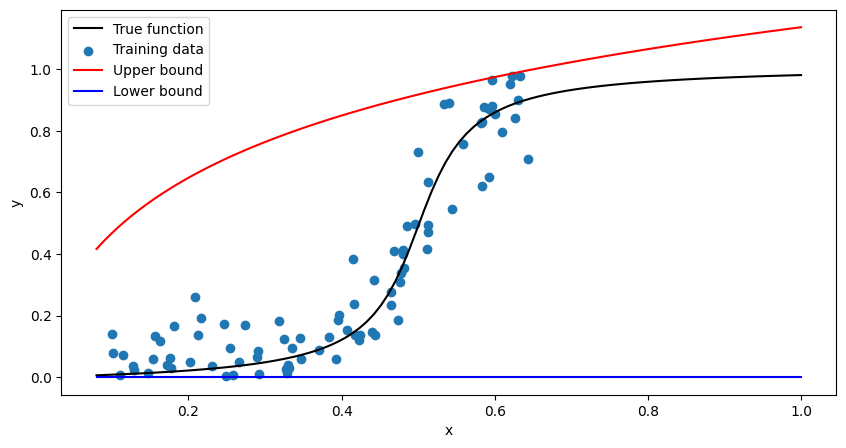

In [10]:
torch.random.seed()
no_points = 300
lengthscale = 1
variance = 1.0
sig_noise = 0.1
def fun(x):
    return (np.arctan(20*x - 10) - np.arctan(-10))/3        
def constant_function(val):
    """ Return the constant function"""
    def fun(x):
        return torch.zeros(x.shape[0])+val
    
    return fun

def fun_UB(x):
    """ Upper bound function """
    return torch.log(25*x.flatten() + 1)/3+0.05      



x_test = np.linspace(0.08, 1, 100)
y_true = fun(x_test)

n = 100
noise_std = 0.1
np.random.seed(1)
x_design = np.random.uniform(0.1, 0.65, n)
x_design.sort(axis = 0)
np.random.seed(10)
y_design = fun(x_design) + np.random.normal(0, noise_std, n)

positive_index=np.where(y_design>=0)[0]
x_design=x_design[positive_index]
y_design=y_design[positive_index]
# diff_y=np.diff(y_design)
# print(diff_y)
# mono_index=(np.where(diff_y<1e-8))[0]+1
train=np.stack((x_design,y_design),axis=-1)
np.random.shuffle(train)

x_mean, x_std = x_design.mean(), x_design.var()**0.5
y_mean, y_std = y_design.mean(), y_design.var()**0.5
# x_train=  torch.FloatTensor(x_design[:,np.newaxis])      
# y_train=  torch.FloatTensor(y_design[:,np.newaxis])      
# x_test=  torch.FloatTensor(x_test)      
# y_true=  torch.FloatTensor(y_true)   
print(x_mean, x_std,y_mean, y_std)


sigma=0.1

ntrain=n

# plot the training data, the true function, and the upper and lower bounds
plt.figure(figsize=(10, 5))
plt.plot(x_test, y_true, 'k', label='True function')
plt.scatter(train[:,0], train[:,1], label='Training data')
plt.plot(x_test, fun_UB(torch.FloatTensor(x_test)), 'r', label='Upper bound')
plt.plot(x_test, constant_function(0)(torch.FloatTensor(x_test)), 'b', label='Lower bound')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

# transfer the data to torch tensors 
x_train=  torch.FloatTensor(train[:,0][:,np.newaxis])
y_train=  torch.FloatTensor(train[:,1][:,np.newaxis])
x_test=  torch.FloatTensor(x_test[:,np.newaxis])
y_true=  torch.FloatTensor(y_true[:,np.newaxis])

dataset = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
# Define the lower bound a(x) = 0 function
def upper_bound_constraint_fn(*args, **kwargs):
    return pred.squeeze()

# Define the upper bound b(x) function
def lower_bound_constraint_fn(*args, **kwargs):
    return pred.squeeze()

# Define the monotone constraint function df/dx_i >= 0
def derivative_constraint_fn(*args, **kwargs):
	dx = args[1]
	pred = regressor_benn(x_test.to(device))[0]
	d_pred = (pred[1] - pred[0])/(2*dx)
	return d_pred.squeeze()
	# return (regressor_benn_derivativeConstraint(X_test.unsqueeze(1).to(device) + dx)[0] - regressor_benn_derivativeConstraint(X_test.unsqueeze(1).to(device) - dx)[0])/(2*dx)



In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = BayesianRegressor(1, 1).to(device)

optimizer = optim.Adam(regressor.parameters(), lr=0.001)
# stepLR scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.25)
criterion = torch.nn.MSELoss()

regressor_benn = BayesianRegressor(1, 2).to(device)
criterion_benn = torch.nn.MSELoss()


In [9]:
# mdmm constraint implementation
# def equality_constraint_fn_1():
#     predictions = regressor_benn(X_test.reshape(-1,1).to(device))
#     return predictions.reshape(-1).squeeze()

# def moment_fn_1(predictions, y_test):
#     return torch.mean((predictions - y_test)**2)

def hard_bound_constraint_fn():
    predictions = regressor_benn(x_train.to(device))
    return predictions.reshape(-1).squeeze()

# value_constraint = mdmm.EqConstraint(equality_constraint_fn_1, y_test.squeeze().to(device))
bound_constraint = mdmm.BoundConstraintHard(hard_bound_constraint_fn, constant_function(0)(x_train).to(device), fun_UB(x_train).to(device))
mdmm_module = mdmm.MDMM()
opt = mdmm_module.make_optimizer(regressor_benn.parameters(), lr = 2e-3)


In [ ]:
import time
iteration = 0
best_loss = 1e6

N = 3
regressor_benn.train()

eta_history = []
loss_history = []
loss_data_history = []
loss_constraint_history = []

best_loss = 1e9
# create summary writer based on datetime
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

writer = SummaryWriter('regression_benn_mdmm_logs/' + current_time)
time_elapsed_ = []
for epoch in range(5000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        start_time = time.time()
        loss_data = regressor_benn.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion_benn,
                           sample_nbr=3,
                           complexity_cost_weight=1/X_train.shape[0])
        mdmm_return = mdmm_module(loss_data)
        opt.zero_grad()
        mdmm_return.value.backward()
        opt.step()
        # check if the loss is lower than the best_loss
        if mdmm_return.value.item() < best_loss:
            best_loss = loss_data
            best_model = regressor_benn
        
        loss_data_history.append(loss_data.item())
        iteration += 1
        end_time = time.time()
        time_elapsed_.append(end_time - start_time)
        if iteration%10==0:
            print("Loss: {:.4f} Loss_data: {:.4f} Constraint_Fn_Value: {:.4f} Infeasibility: {:.4f}".format(mdmm_return.value.item(), 
                                                                                                            loss_data.item(), mdmm_return.fn_values[0].item(), 
                                                                                                            mdmm_return.infs[0].item()))
            print('-----------------------------')
            writer.add_scalar('Loss/loss_data', loss_data.item(), iteration)
            writer.add_scalar('Loss/total_loss', mdmm_return.value.item(), iteration)
            writer.add_scalar('Loss/constraint_fn_value', mdmm_return.fn_values[0].item(), iteration) # TODO: assuming one constraint. What if there are multiple constraints?
            writer.add_scalar('Constraint Infeasibility', mdmm_return.infs[0].item(), iteration)
            writer.add_scalar('Lagrange Multiplier', mdmm_module[0].lmbda.item(), iteration)
            writer.flush()


In [ ]:
mean_time_elapsed = np.mean(time_elapsed_)
print('Mean time elapsed: {:.4f}'.format(mean_time_elapsed))

In [ ]:
# Plot the training data, and the learned function using test data linearly spaced torch tensor
plt.figure(figsize=(10, 6))
# size of scatter points = 10, and test points need to be stars not circles
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
plt.scatter(X_test, y_test, color='red', label='Test Data', marker='*', s=100)
# plt.scatter(60.0, 30.0, color='green', label='Range Constraint - Lower Bound', marker='*', s=100)
# plt.scatter(60.0, 60.0, color='green', label='Range Constraint - Upper Bound', marker='*', s=100)
# linspaced test data
x_plot = torch.linspace(-5, 100, 1000).reshape(-1,1)

# y_plot = best_model(x_plot.to(device)).cpu().detach().numpy()
# preds = [best_model(x_plot.to(device)).cpu().detach().numpy() for _ in range(100)]
# preds = np.stack(preds)
# mean = preds.mean(axis=0)
# std = preds.std(axis=0)
# ci_upper = mean + (1 * std)
# ci_lower = mean - (1 * std)

# y_plot_benn = best_model_benn(x_plot.to(device)).cpu().detach().numpy()
preds_benn = [best_model(x_plot.to(device)).cpu().detach().numpy() for _ in range(100)]
preds_benn = np.stack(preds_benn)
mean_benn = preds_benn.mean(axis=0)
std_benn = preds_benn.std(axis=0)
ci_upper_benn = mean_benn + (25*std_benn)
ci_lower_benn = mean_benn - (25*std_benn)

# Compute MSE loss on train, test set and constraint set
mae_loss = nn.L1Loss()
loss_training = []
loss_val_constraints = []
for i in range(100):
    loss_training.append(mae_loss(best_model(X_train.to(device)), y_train.to(device)))
    loss_val_constraints.append(mae_loss(best_model(X_test.to(device)).reshape(len(X_test),), y_test.to(device)))
print('Training loss: ', torch.stack(loss_training).mean())
print('Val constraint loss: ', torch.stack(loss_val_constraints).mean())

# extract x_plot values between 25 and 27
# x_plot_deriv = x_plot[(x_plot>=10) & (x_plot<=11)]
# # compute line with slope dy_test_3, and y-intercept at mean_benn of x_plot_deriv >= 25 and <= 25.50
# y_plot_deriv = dy_test_3*(x_plot_deriv)


# plt.plot(x_plot, mean, color='red', label='Learned Function')
# plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='orange', alpha=0.25)
plt.plot(x_plot, mean_benn, color='yellow', label='Learned Function with BENN Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower_benn.squeeze(), ci_upper_benn.squeeze(), color='blue', alpha=0.25)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# Plot loss histories 
'''
loss_data_history = (loss_data_history - np.min(loss_data_history))/(np.max(loss_data_history) - np.min(loss_data_history))
loss_constraint_1_history = (loss_constraint_1_history - np.min(loss_constraint_1_history))/(np.max(loss_constraint_1_history) - np.min(loss_constraint_1_history))
# loss_constraint_2_history = (loss_constraint_2_history - min(loss_constraint_2_history))/(max(loss_constraint_2_history) - min(loss_constraint_2_history))
# loss_constraint_3_history   = (loss_constraint_3_history - min(loss_constraint_3_history))/(max(loss_constraint_3_history) - min(loss_constraint_3_history))
plt.figure(figsize=(10, 6))
plt.plot(loss_data_history, color='blue', label='Data Loss')
plt.plot(loss_constraint_1_history, color='green', label='Constraint 1 Loss')
# plt.plot(loss_constraint_2_history, color='red', label='Constraint 2 Loss')
# plt.plot(loss_constraint_3_history, color='yellow', label='Constraint 3 Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot eta history
plt.figure(figsize=(10, 6))
plt.plot(eta_history, color='blue', label='eta')
plt.xlabel('Iteration')
plt.ylabel('eta')
plt.legend()
plt.show()

'''